In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
df = yf.download('EURUSD=X', start ='2008-10-9')['Adj Close'].to_frame()

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.head()

,Adj Close
Date,
2008-10-09,1.359804
2008-10-10,1.339800
2008-10-13,1.362194
2008-10-14,1.361804
2008-10-15,1.344393


We use the logaritmic returns because it is easier to do the computation for returns on time periods. Thanks to the logarithm properties we can just sum the log return.

In [5]:
df['logRet'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))

df.dropna(inplace=True)

(-0.04, 0.04)

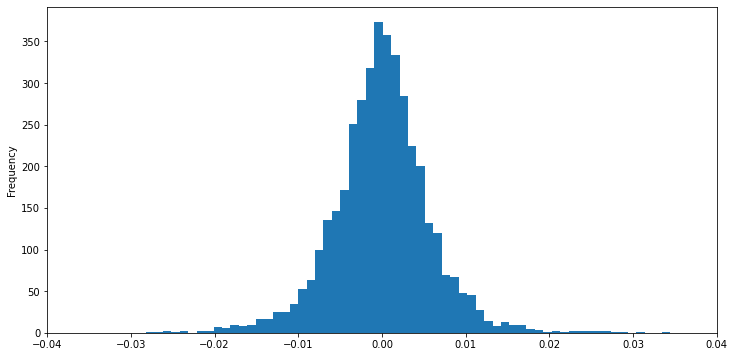

In [6]:
plt.figure(figsize=(12,6))
df.logRet.plot(kind='hist', bins=300)
plt.xlim(-0.04, 0.04)

To compute the total return for the whole period, we can just sum the log returns:

In [7]:
df.logRet.sum()

-0.24354860268102552

If we want to see the how much is worth now a dollar bought at the beginning of the period compared to a euro now, or we can see it as investing 1 EUR in USD at the beginning of the period  how much is worth it now:

$LR = log \frac{P_{end}}{P_{start}}$

We apply the exponent to both side:

$e^{LR} = \frac{P_{end}}{P_{start}}$

So we can write:

$P_{end} = P_{start} \times e^{LR}$

In [8]:
dollar_price_start = 1
dollar_value_now = np.exp(df.logRet.sum()) * dollar_price_start
dollar_value_now

0.78384137831397

If we want to compute the cumulative log return till a certain time $T$, we can use the pandas function *cumsum()* that does it for us:

In [9]:
df['cumLogRet'] = df.logRet.cumsum()

df.head(5)

,Adj Close,logRet,cumLogRet
Date,,,
2008-10-10,1.339800,-0.014820,-0.014820
2008-10-13,1.362194,0.016576,0.001756
2008-10-14,1.361804,-0.000286,0.001470
2008-10-15,1.344393,-0.012868,-0.011398
2008-10-16,1.349000,0.003421,-0.007977


Where we can see that:

$cumLogRet_T = \sum_{t=1}^{T} logRet_t = logRet_{T} + logRet_{T-1} + logRet_{T-2} + \ldots + logRet_{start}$.

If we want to see the value through time of 1 USD bought at the beginning, we can apply the formula we saw above:

In [10]:
df['value1USD'] = df.logRet.cumsum().apply(np.exp)

df.head()

,Adj Close,logRet,cumLogRet,value1USD
Date,,,,
2008-10-10,1.339800,-0.014820,-0.014820,0.985289
2008-10-13,1.362194,0.016576,0.001756,1.001757
2008-10-14,1.361804,-0.000286,0.001470,1.001471
2008-10-15,1.344393,-0.012868,-0.011398,0.988667
2008-10-16,1.349000,0.003421,-0.007977,0.992054


<Axes: xlabel='Date'>

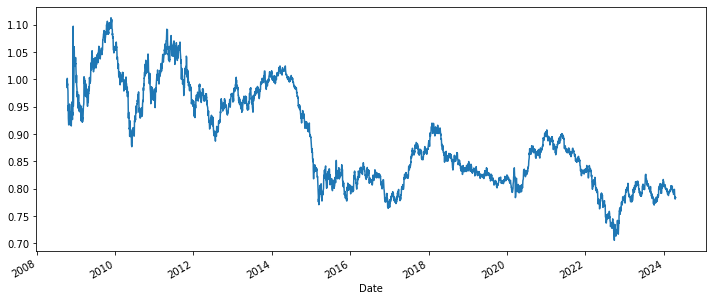

In [11]:
# Value of 1 USD compared to EUR
plt.figure(figsize=(12,5))
df.value1USD.plot()

# Performance metrics

In [12]:
df.describe()

,Adj Close,logRet,cumLogRet,value1USD
count,4047.000000,4047.000000,4047.000000,4047.000000
mean,1.210073,-0.000060,-0.121672,0.889888
std,0.122262,0.006724,0.099716,0.089911
min,0.959619,-0.143324,-0.348559,0.705704
25%,1.107992,-0.003227,-0.204791,0.814817
50%,1.179468,0.000000,-0.142277,0.867381
75%,1.317506,0.003106,-0.031600,0.968894
max,1.512791,0.159632,0.106615,1.112506


In [13]:
# Mean daily returns
print('Mean daily return:',df.logRet.mean())
# Median daily returns
print('Median daily return:',df.logRet.median())
# Volatility (computed on daily returns)
print('Volatility:',df.logRet.std())
# Absolute return (on the whole period)
print('Absolute return:',df.cumLogRet[-1]) # sum of all logreturns

Mean daily return: -6.01800352559984e-05
Median daily return: 0.0
Volatility: 0.006723817102942826
Absolute return: -0.24354860268102527


In [16]:
# Just a way to compute the number of tradable day in a year
tmp = df[df['Adj Close'].to_frame().index>=pd.to_datetime('2013-01-01')]
tmp = tmp[tmp['Adj Close'].to_frame().index<pd.to_datetime('2014-01-01')]
print(len(tmp))

260


Usually to compare investments metrics, we need to compare taking in cosideration the same time periods. For this reason usually we use the annual metrics. For this reason we multiply by the number of yearly trading days we found before.

In [43]:
# Mean annual returns
print('Mean daily return:',df.logRet.mean()*260)
# Median annual returns
print('Median daily return:',df.logRet.median()*260)
# Volatility (computed on daily returns)
print('Volatility:',df.logRet.std()*np.sqrt(260))

Mean daily return: -0.01563697207847765
Median daily return: 0.0
Volatility: 0.108429674913964


In [46]:
# Absolute annual return
# Must be normalized by the number of traded days
print('Absolute return:',df.cumLogRet[-1]*260/len(df)) # sum of all logreturns

Absolute return: -0.015636972078477633


# Max Drawdown

Usually trader do not use volatility to trade, but they use drawdown. Drawdown is the difference between the maximum cumulative return and the actual cumulative return. What does it mean? It can happen (almost always) that the trader do not sell when price is at its maximum value, but after it is lower (can still be profitable, but not as profitable as if the price was at its max). So it's kinda the "error" of the selling strategy.

In [47]:
df['cumLogRetMax'] = df.cumLogRet.cummax()

<Axes: xlabel='Date'>

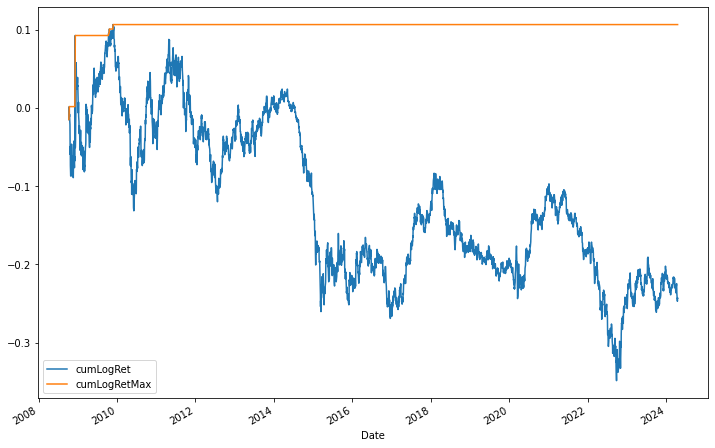

In [55]:
df[['cumLogRet', 'cumLogRetMax']].plot(figsize=(12,8))

Looking at the plot we can see that the orange line is like the optimal value, and we can see the difference between the actual return and the best return we could have.

In [50]:
drawdown = df.cumLogRetMax - df.cumLogRet

<Axes: xlabel='Date'>

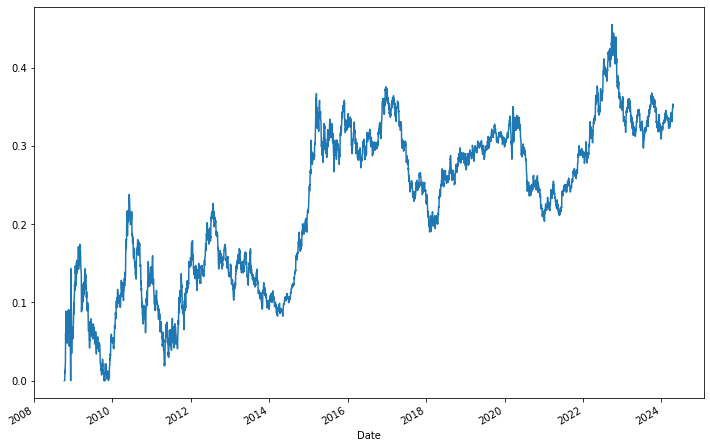

In [52]:
plt.figure(figsize=(12,8))
drawdown.plot()

In [57]:
drawdown.max(), drawdown.idxmax() # what traders want to know

(0.45517485444477696, Timestamp('2022-09-28 00:00:00'))